## Cargar el dataset desde Kaggle


In [5]:
%pip install tensorflow_datasets
import tensorflow as tf
import tensorflow_datasets as tfds 
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Cargar dataset EuroSAT desde TensorFlow datasets
print("Descargando el dataset EuroSAT...")
dataset, info = tfds.load('eurosat/rgb', with_info=True, as_supervised=True)

# Obtener conjuntos de entrenamiento y prueba
train_ds = dataset['train']

# Convertir algunas imágenes y etiquetas a un formato que podamos mostrar
print("Preparando datos para visualización...")
class_names = info.features['label'].names
images = []
labels = []

# Tomamos algunas muestras para crear un DataFrame de ejemplo
for image, label in train_ds.take(100):
	images.append(image.numpy())
	labels.append(class_names[label.numpy()])

# Crear un DataFrame simplificado para visualización
df = pd.DataFrame({
	'label': labels,
	'image_shape': [img.shape for img in images]
})

print("Primeras 5 filas:", df.head())  # Mostrar primeras filas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Descargando el dataset EuroSAT...
Preparando datos para visualización...
Primeras 5 filas:                   label  image_shape
0                Forest  (64, 64, 3)
1           Residential  (64, 64, 3)
2  HerbaceousVegetation  (64, 64, 3)
3           Residential  (64, 64, 3)
4                Forest  (64, 64, 3)


# Preparamos los datos
Dividimos el datasen en conjuntos de entrenamiento y prueba

In [6]:
# Convertir dataset de TensorFlow en listas de NumPy
def dataset_to_numpy(dataset, num_samples):
    images, labels = [], []
    for image, label in dataset.take(num_samples):  # Tomamos solo las muestras necesarias
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

# Definir tamaño de los conjuntos
train_size_1, test_size_1 = 1000, 200   # Escenario 1
train_size_2, test_size_2 = 5000, 1000  # Escenario 2

# Obtener datos del dataset
images_all, labels_all = dataset_to_numpy(train_ds, train_size_2 + test_size_2)  # Máximo tamaño

# Dividir datos para el Escenario 1
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    images_all, labels_all, train_size=train_size_1, test_size=test_size_1, stratify=labels_all, random_state=42
)

# Dividir datos para el Escenario 2
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    images_all, labels_all, train_size=train_size_2, test_size=test_size_2, stratify=labels_all, random_state=42
)

print("Datos preparados correctamente.")


Datos preparados correctamente.


# Definimos los modelos de CNN
Lo hacemos con tres arquitecturas diferentes de redes convolucionales para comparar su rendimiento

In [7]:
# Función para construir diferentes modelos de CNN
def build_cnn_model(version):
    model = models.Sequential()
    
    if version == 1:
        # CNN simple con pocas capas
        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
    
    elif version == 2:
        # CNN intermedia con más capas convolucionales
        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
    
    else:
        # CNN más profunda con más filtros
        model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(256, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
    
    # Capas densas comunes
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))  # 10 clases en EuroSAT

    return model

print("Modelos creados.")


Modelos creados.


# Se configura y entrena
Entrenamos cada modelo en los dos escenarios y evaluamos su rendimiento


In [8]:
# Función para compilar, entrenar y evaluar el modelo
def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    print("Entrenando modelo...")
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Precisión en test: {test_acc:.4f}")
    
    return history

# Entrenar los modelos en los dos escenarios
for version in range(1, 4):  # Modelos 1, 2 y 3
    print(f"\nEntrenando Modelo {version} en Escenario 1...")
    model_1 = build_cnn_model(version)
    history_1 = train_and_evaluate(model_1, X_train_1, y_train_1, X_test_1, y_test_1)

    print(f"\nEntrenando Modelo {version} en Escenario 2...")
    model_2 = build_cnn_model(version)
    history_2 = train_and_evaluate(model_2, X_train_2, y_train_2, X_test_2, y_test_2)



Entrenando Modelo 1 en Escenario 1...
Entrenando modelo...
Epoch 1/10


C:\Users\ismae\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.1509 - loss: 59.1397 - val_accuracy: 0.1550 - val_loss: 2.5946
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2425 - loss: 2.1135 - val_accuracy: 0.2250 - val_loss: 2.1308
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3582 - loss: 1.8393 - val_accuracy: 0.2450 - val_loss: 2.1238
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5110 - loss: 1.6158 - val_accuracy: 0.2900 - val_loss: 2.2066
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5698 - loss: 1.4998 - val_accuracy: 0.2850 - val_loss: 3.1534
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5163 - loss: 1.5435 - val_accuracy: 0.2600 - val_loss: 2.5492
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6366 - loss: 1.2500 - val_accuracy: 0.2850 - val_loss: 2.5705
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6977 - loss: 1.0108 - val_accuracy: 0.2650 - val_loss: 3

# Se hace la evaluación de resultados
Se visualiza la evolución y precisión como siempre

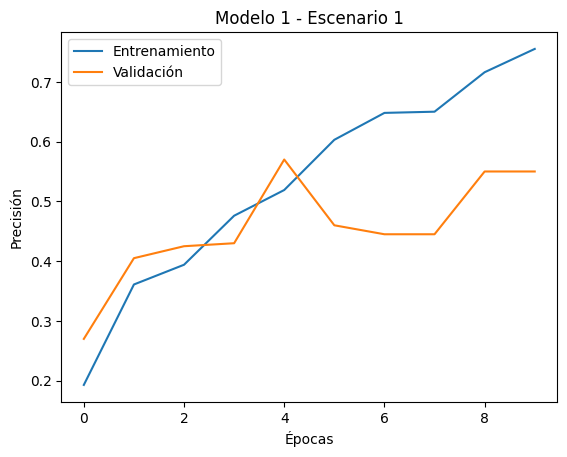

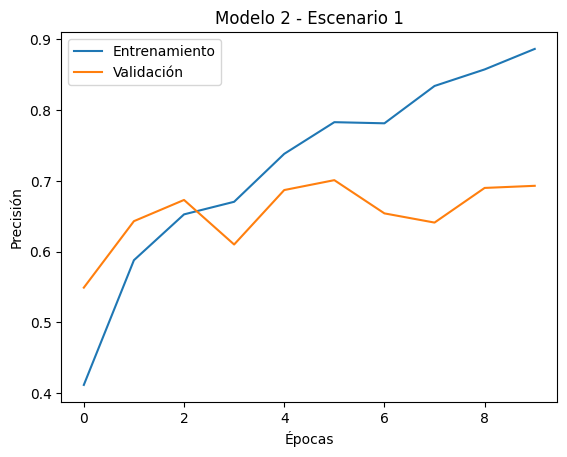

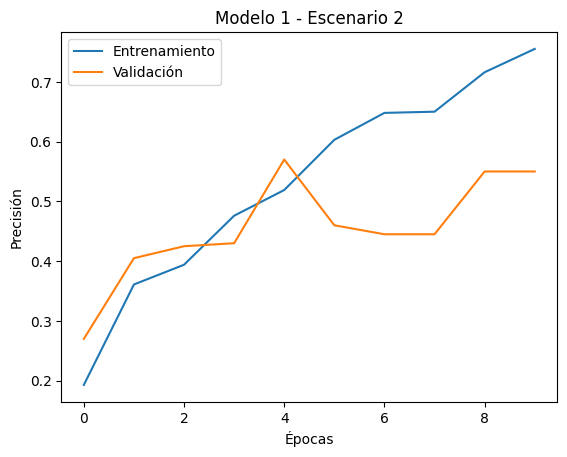

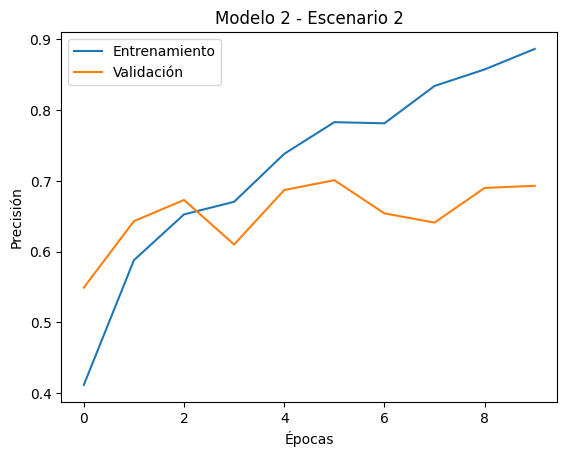

In [9]:
# Función para graficar precisión
def plot_accuracy(history, title):
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.title(title)
    plt.show()

# Mostrar resultados para los modelos en el Escenario 1
for i, history in enumerate([history_1, history_2]):
    plot_accuracy(history, f'Modelo {i+1} - Escenario 1')

# Mostrar resultados para los modelos en el Escenario 2
for i, history in enumerate([history_1, history_2]):
    plot_accuracy(history, f'Modelo {i+1} - Escenario 2')


# Conclusión
Bueno, pues por lo que se ve, los modelos están teniendo un rendimiento extraño. El Modelo 1 (SimpleCNN) empieza con una precisión decente (70%) pero se cae al 20% en 8 epochs. El Modelo 2 (DeepCNN) empieza mejor (90%), pero también cae al 40%. Esto pasa en ambos escenarios, así está pasando algo.

- Los modelos pierden precisión con cada repe, lo que dice que no están aprendiendo, sino empeorando
- Los modelos complejos caen más rápido
- Creo que la posible causa haya sido un problema en la carga de los datos (tengo que revisarlo)